## some new decoding analyses... 

### 1. if the same subset of images in NS1 can be decoded if train/test is just NS1

### 2. if the first 20% of trials in NS2 is decodable

### 3. if "time" or trial number is decodable from NS2

In [2]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [13]:
stim_table.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
944 / 8

118.0

In [61]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '25'
plane = 6
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "natural_images_12") # T x N

stim_table, _ = session.get_stimulus_table("natural_images_12")
num_splits = 4
assert len(stim_table) % num_splits == 0, "Number of trials must be divisible by num_splits"
y_data = np.array(list(range(1, num_splits + 1))).repeat(int(len(stim_table) / num_splits)) ## essentially bin trials into start (0), middle (1), end (2) of the time

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Perform k-NN classification with hyperparameter tuning
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k_HIGH = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k_HIGH, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print('HIGH PERFORMANCE EXAMPLE')
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

HIGH PERFORMANCE EXAMPLE
Training accuracy: 1.0
Test accuracy: 0.4270833333333333


Text(0.5, 1.0, 'Confusion Matrix for Natural Images Decoding')

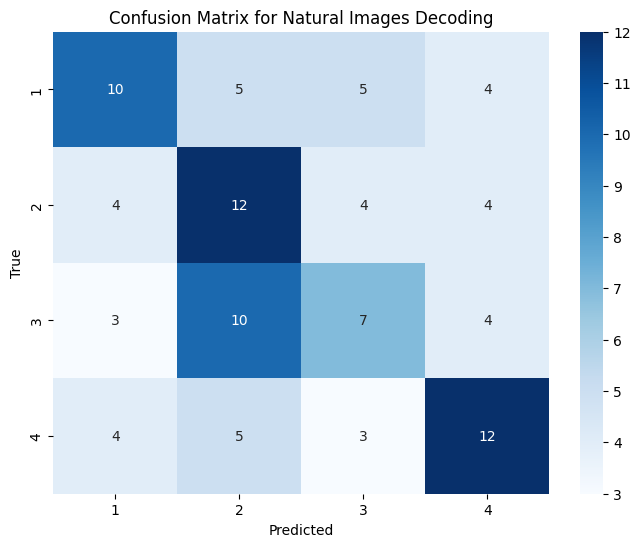

In [62]:
## confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, num_splits+1), yticklabels=range(1, num_splits+1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Natural Images Decoding')